# Problem Definition
This project aims to recommend a suitable crop to grow based on environmental conditions like nitrogen, phosphorous, potassium, temperature, humidity, pH, and rainfall.


In [5]:
!pip install mlflow

   ---------------------------------------- 0.0/24.7 MB ? eta -:--:--
   -- ------------------------------------- 1.6/24.7 MB 9.7 MB/s eta 0:00:03
   ------ --------------------------------- 3.9/24.7 MB 10.6 MB/s eta 0:00:02
   ---------- ----------------------------- 6.3/24.7 MB 10.6 MB/s eta 0:00:02
   -------------- ------------------------- 8.7/24.7 MB 10.7 MB/s eta 0:00:02
   ----------------- ---------------------- 11.0/24.7 MB 10.9 MB/s eta 0:00:02
   --------------------- ------------------ 13.4/24.7 MB 11.0 MB/s eta 0:00:02
   ------------------------- -------------- 15.7/24.7 MB 11.1 MB/s eta 0:00:01
   ----------------------------- ---------- 18.4/24.7 MB 11.2 MB/s eta 0:00:01
   --------------------------------- ------ 20.4/24.7 MB 11.2 MB/s eta 0:00:01
   ------------------------------------ --- 22.8/24.7 MB 11.2 MB/s eta 0:00:01
   ---------------------------------------  24.6/24.7 MB 11.2 MB/s eta 0:00:01
   ---------------------------------------- 24.7/24.7 MB 10.8 MB/s

###  **Data Preprocessing**

### DVC initialisation

In [22]:
!dvc init
!dvc add data/crop_recommendation.csv
!git add data/crop_recommendation.csv.dvc .gitignore
!git commit -m "Add raw crop data with DVC tracking"


'dvc' is not recognized as an internal or external command,
operable program or batch file.
'dvc' is not recognized as an internal or external command,
operable program or batch file.
fatal: pathspec 'data/crop_recommendation.csv.dvc' did not match any files


On branch main
Your branch is ahead of 'origin/main' by 1 commit.
  (use "git push" to publish your local commits)

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   MLPRJ.ipynb
	modified:   random_forest_model.pkl

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	label_encoder.pkl
	mlruns/799976923787763083/1f094246fdfc4b35a9a1ef5122beb2ef/
	mlruns/799976923787763083/3dceb678426243968609b86ba40d5e99/
	mlruns/799976923787763083/415f275fbc394ea696d0c14247e580d0/
	mlruns/799976923787763083/74fa90167eed4723946f1de24388cdbf/
	mlruns/799976923787763083/b6e743adca2646caab06b0b8080a63ac/
	mlruns/799976923787763083/c24be888ec82403ea73031383313b590/
	mlruns/799976923787763083/e0c47985324c485a9efaf109d1d4552a/
	mlruns/799976923787763083/fbd7d29e6b494781b2d33374850df13c/
	mlruns/799976923787763083/models/m-20ae037b30de40dd85a1e4d549964150

In [24]:
#load the dataset
raw_path = "data/crop_recommendation.csv"
df = pd.read_csv(raw_path)

In [25]:
# drop NA vakues
df_clean = df.dropna()

In [26]:
# Handle outliers using IQR method
def remove_outliers_iqr(data, features):
    for col in features:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        before = data.shape[0]
        data = data[(data[col] >= lower) & (data[col] <= upper)]
        after = data.shape[0]
        print(f"{col}: removed {before - after} outliers")
    return data

features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
df_clean = remove_outliers_iqr(df_clean, features)

N: removed 0 outliers
P: removed 138 outliers
K: removed 62 outliers
temperature: removed 58 outliers
humidity: removed 0 outliers
ph: removed 58 outliers
rainfall: removed 38 outliers


In [27]:
# Save processed CSV
processed_path = "data/processed_crop.csv"
df_clean.to_csv(processed_path, index=False)
print(f"Processed data saved to: {processed_path}")

Processed data saved to: data/processed_crop.csv


In [31]:
# DVC tracking for processed data

!dvc add data/processed_crop.csv
!git add data/processed_crop.csv.dvc
!git commit -m "Add processed crop dataset after cleaning"


'dvc' is not recognized as an internal or external command,
operable program or batch file.
fatal: pathspec 'data/processed_crop.csv.dvc' did not match any files


On branch main
Your branch is ahead of 'origin/main' by 1 commit.
  (use "git push" to publish your local commits)

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   MLPRJ.ipynb
	modified:   data/processed_crop.csv
	modified:   random_forest_model.pkl

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	data/heatmap_after_cleaning.png
	label_encoder.pkl
	mlruns/799976923787763083/1f094246fdfc4b35a9a1ef5122beb2ef/
	mlruns/799976923787763083/3dceb678426243968609b86ba40d5e99/
	mlruns/799976923787763083/415f275fbc394ea696d0c14247e580d0/
	mlruns/799976923787763083/74fa90167eed4723946f1de24388cdbf/
	mlruns/799976923787763083/b6e743adca2646caab06b0b8080a63ac/
	mlruns/799976923787763083/c24be888ec82403ea73031383313b590/
	mlruns/799976923787763083/e0c47985324c485a9efaf109d1d4552a/
	mlruns/799976923787763083/fbd7d29e6b494781b2d33374850df13c

### **Visualising Insights**

### Avg value in each crop type

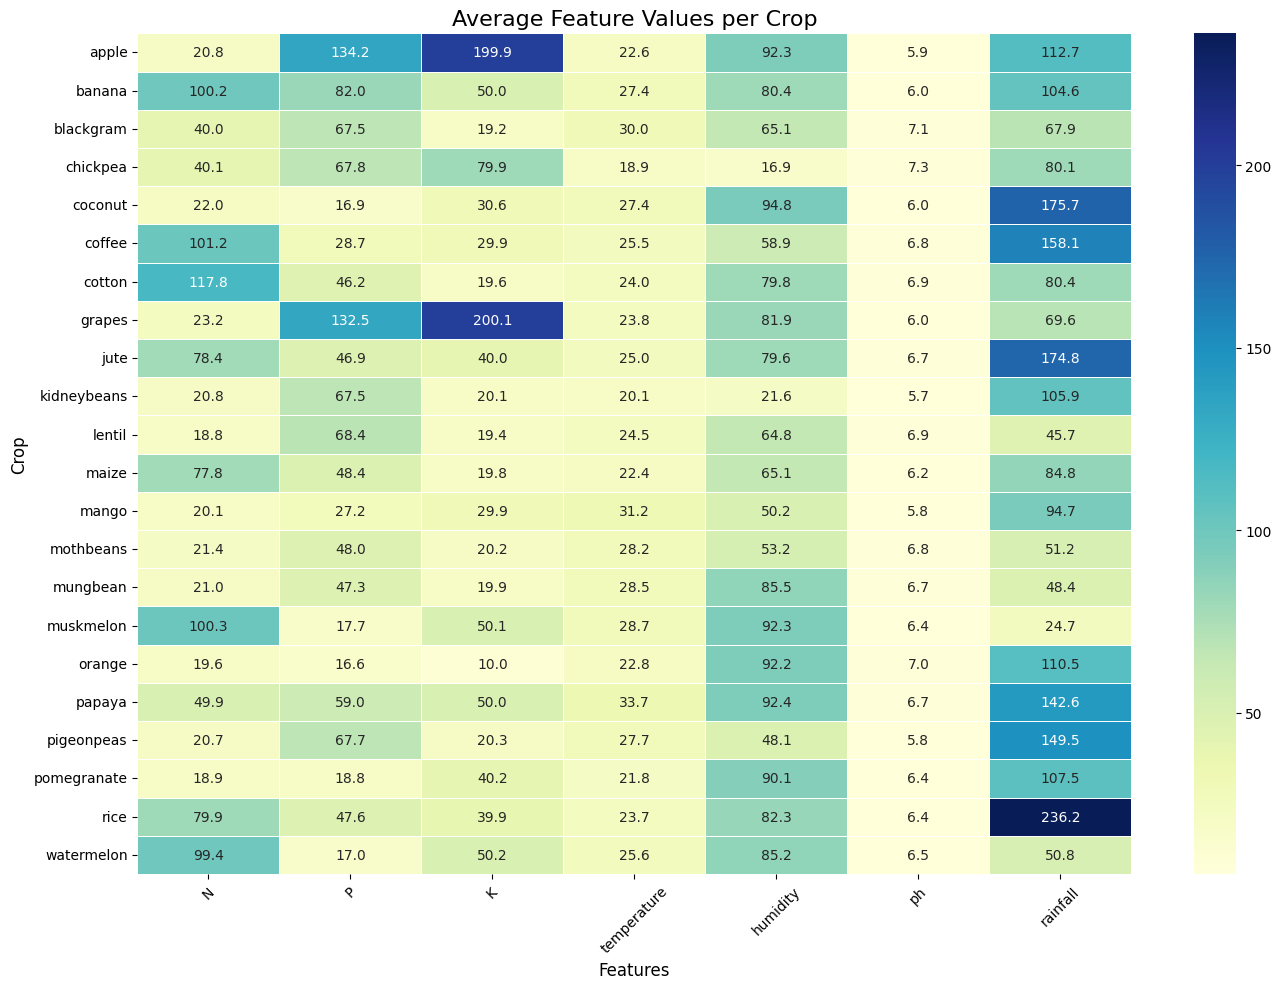

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your CSV
df = pd.read_csv("data/crop_recommendation.csv")

# Group by crop and calculate mean of each feature
avg_features_per_crop = df.groupby("label").mean(numeric_only=True).reset_index()

# Set crop as index for better visualization
avg_features_per_crop.set_index("label", inplace=True)

# Plot as heatmap using seaborn 
plt.figure(figsize=(14, 10))
sns.heatmap(avg_features_per_crop, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=0.5)

plt.title("Average Feature Values per Crop", fontsize=16)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Crop", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Bar chart – average values of each feature for each crop type

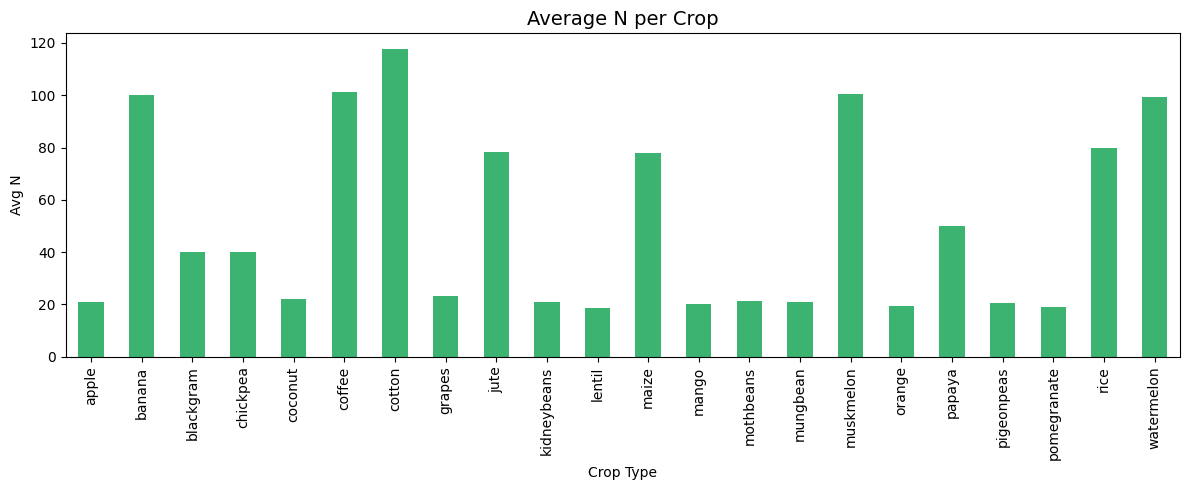

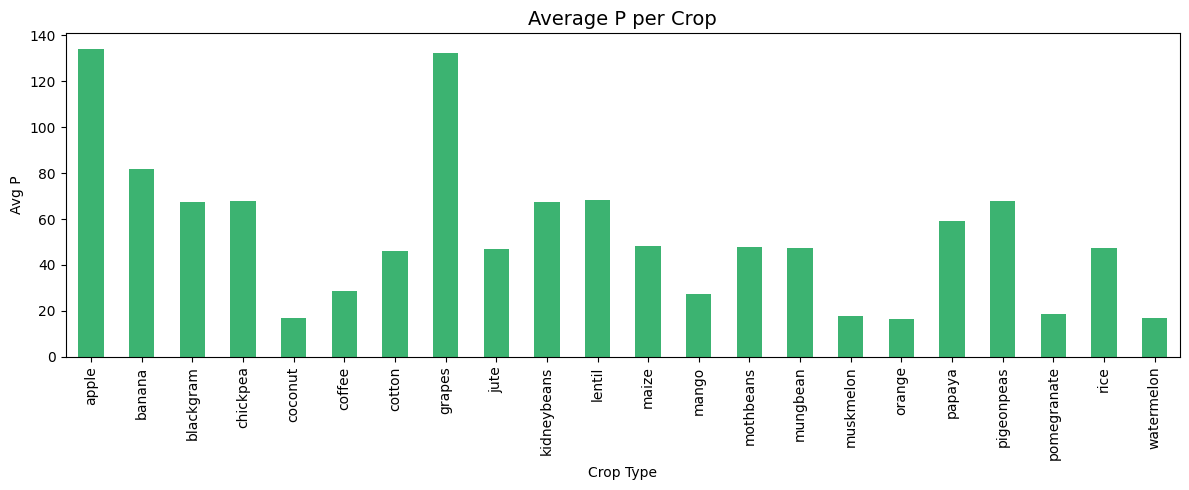

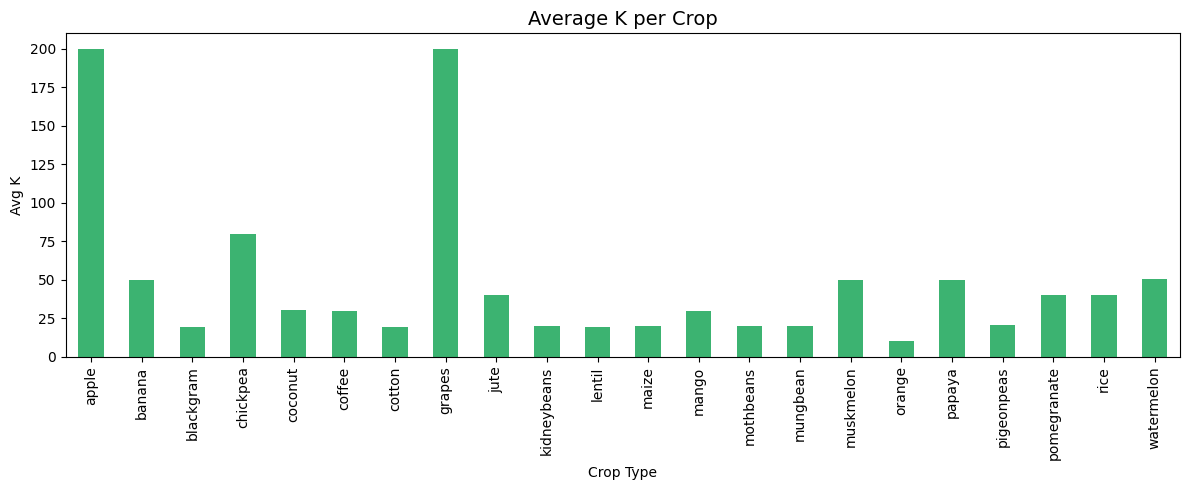

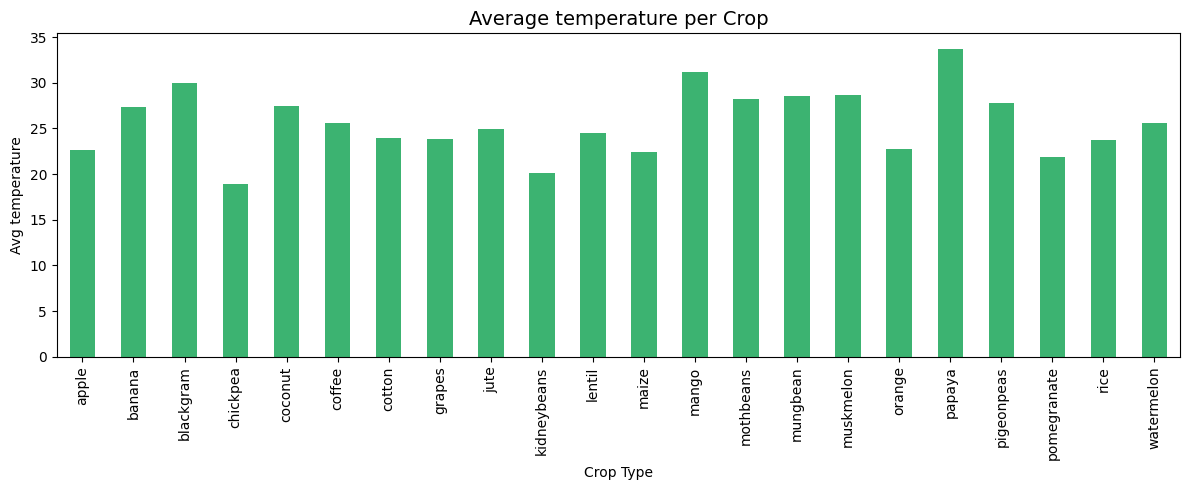

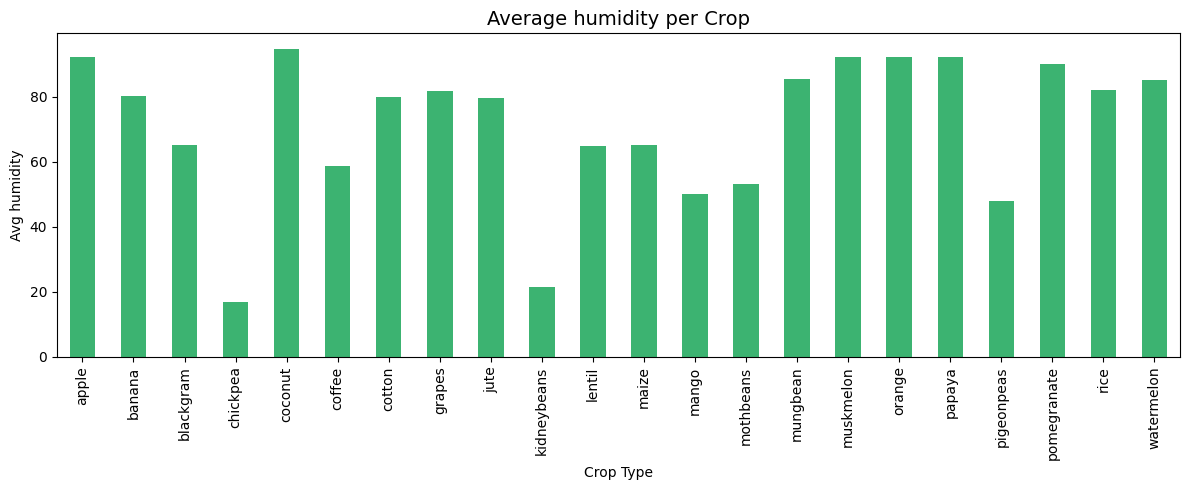

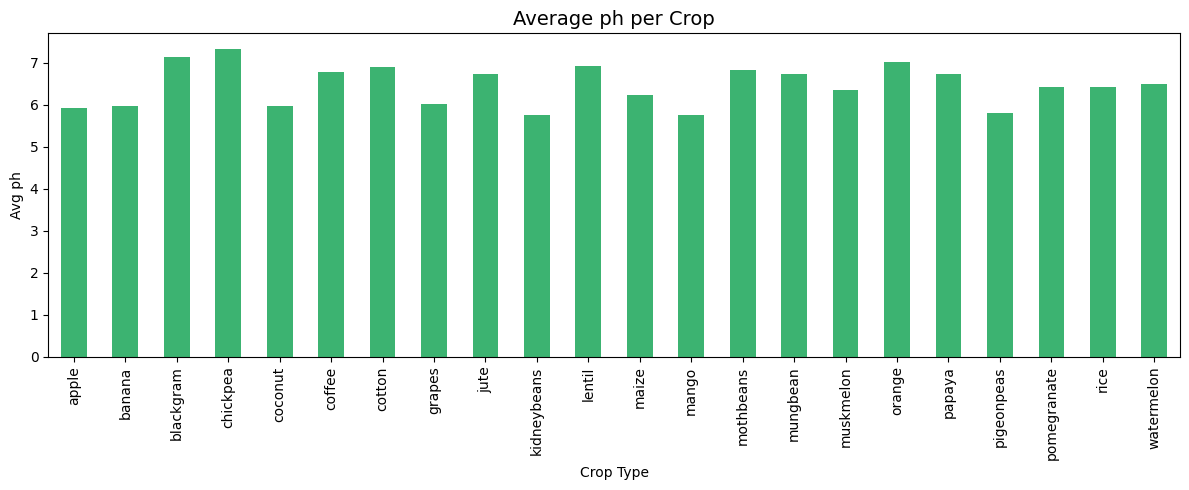

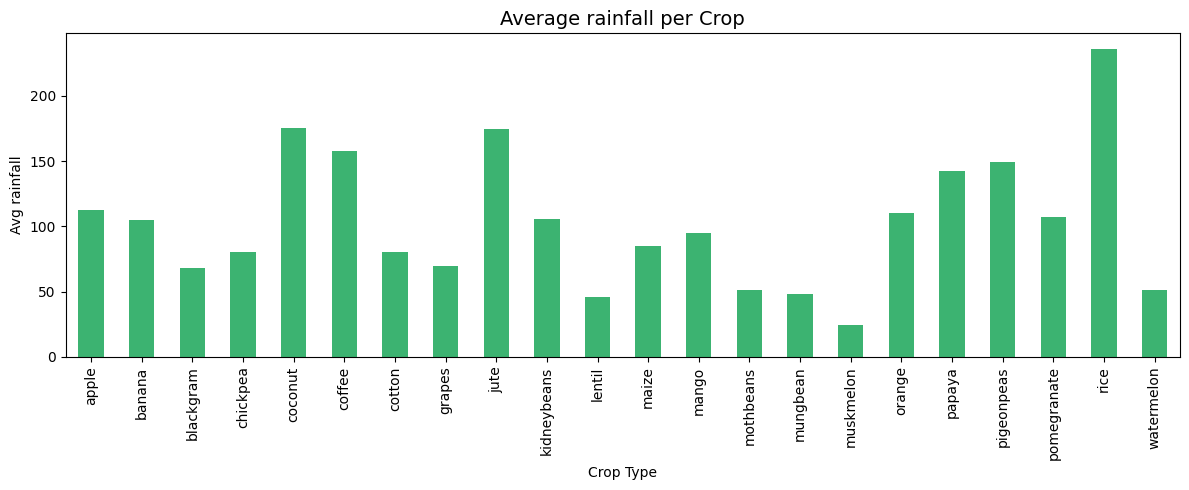

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV
df = pd.read_csv("data/crop_recommendation.csv")

# Group by crop and calculate average values
avg_features = df.groupby("label").mean(numeric_only=True)

# Plot individual bar chart for each feature
for feature in avg_features.columns:
    plt.figure(figsize=(12, 5))
    avg_features[feature].plot(kind='bar', color='mediumseagreen')
    plt.title(f"Average {feature} per Crop", fontsize=14)
    plt.ylabel(f"Avg {feature}")
    plt.xlabel("Crop Type")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


### Min and Max values of features per crop type 

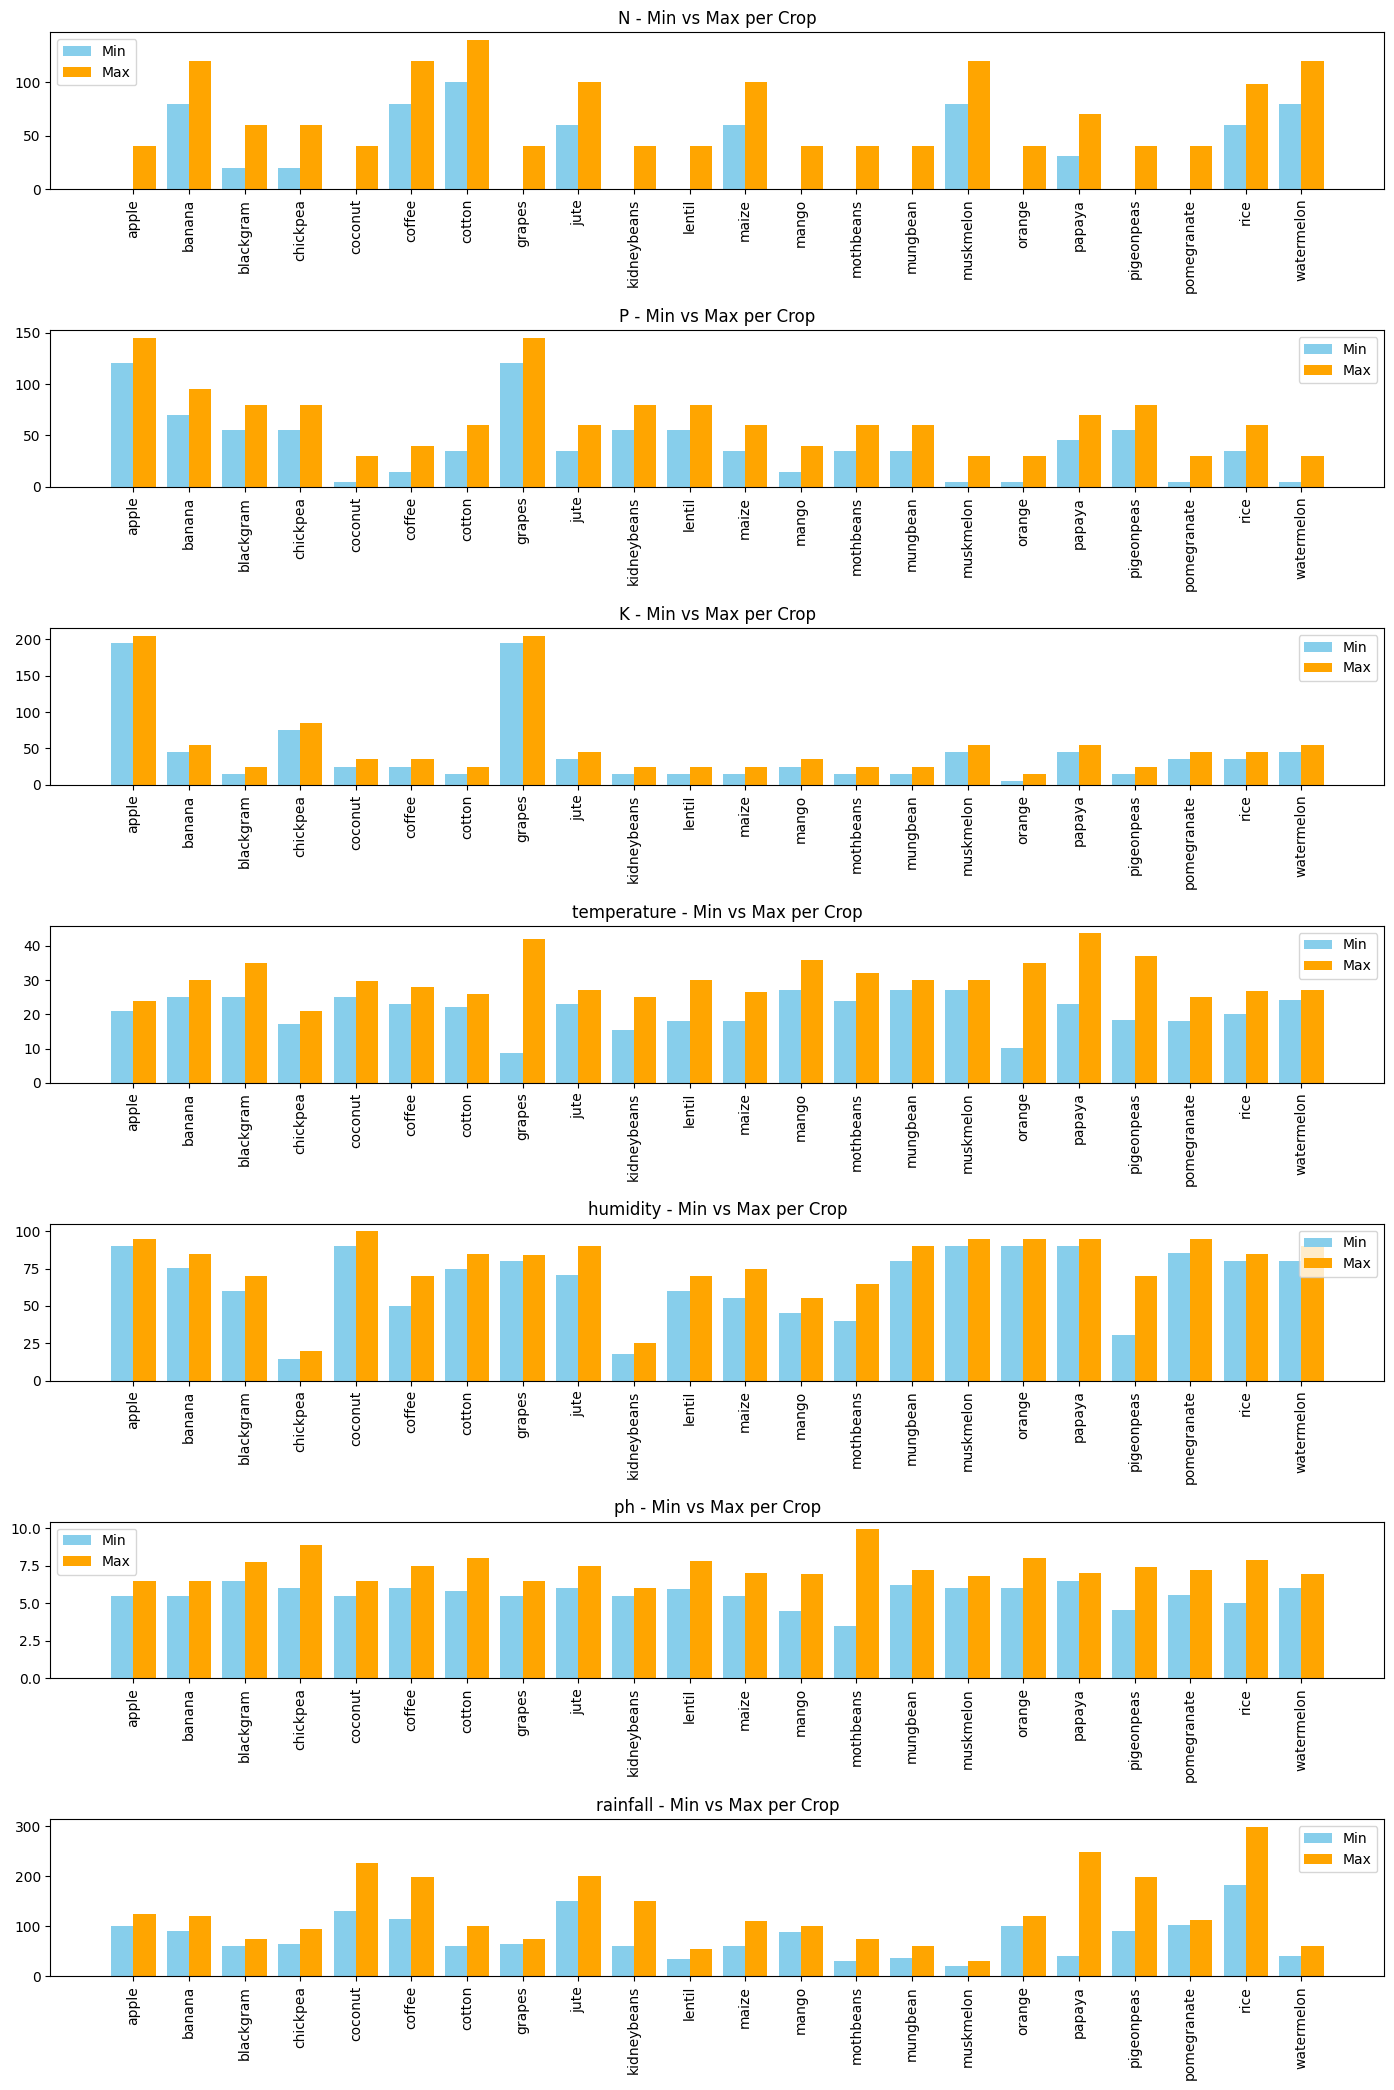

In [34]:
import numpy as np

# Group by crop and get min and max
min_features = df.groupby("label").min(numeric_only=True)
max_features = df.groupby("label").max(numeric_only=True)

# Create subplots for each feature
features = df.columns[:-1]  # Exclude label column
num_features = len(features)

fig, axes = plt.subplots(nrows=num_features, figsize=(14, 3 * num_features))

for i, feature in enumerate(features):
    ax = axes[i]
    x = np.arange(len(min_features.index))
    ax.bar(x - 0.2, min_features[feature], width=0.4, label="Min", color='skyblue')
    ax.bar(x + 0.2, max_features[feature], width=0.4, label="Max", color='orange')
    ax.set_title(f"{feature} - Min vs Max per Crop")
    ax.set_xticks(x)
    ax.set_xticklabels(min_features.index, rotation=90)
    ax.legend()

plt.tight_layout()
plt.show()


In [35]:


import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


### Load Dataset

In [36]:
df = pd.read_csv("data/crop_recommendation.csv")
X = df.drop("label", axis=1)
y = df["label"]

### Encode Lables

In [37]:
# During model training
from sklearn.preprocessing import LabelEncoder
import pickle

le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Save label encoder
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


### SVM is sensitive to the numbers so we normalize each feature so that all the features are in equal scale 

In [39]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### store the models in a dict to use it later 

In [40]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=200),
    "RandomForest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
}

### Now we start tracking the experiment

In [41]:
mlflow.set_experiment("Crop Recommendation Model Comparison")

for model_name, model in models.items():
    with mlflow.start_run(run_name=model_name):
        print(f"Training {model_name}...")

        # Use scaled data for some models
        if model_name in ["KNN", "SVM", "LogisticRegression"]:
            model.fit(X_train_scaled, y_train)
            predictions = model.predict(X_test_scaled)
        else:
            model.fit(X_train, y_train)
            predictions = model.predict(X_test)
        # Calculate accuracy
        acc = accuracy_score(y_test, predictions)

        # Log the parameters, metrics, and model
        mlflow.log_param("model_name", model_name)
        mlflow.log_metric("accuracy", acc)
        mlflow.sklearn.log_model(model, f"{model_name}_model")

        print(f"{model_name} Accuracy: {acc:.4f}")

2025/07/17 11:29:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Training LogisticRegression...


2025/07/17 11:29:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LogisticRegression Accuracy: 0.9636
Training RandomForest...


2025/07/17 11:29:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/17 11:29:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/17 11:29:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


RandomForest Accuracy: 0.9932
Training KNN...


2025/07/17 11:29:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/17 11:29:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


KNN Accuracy: 0.9568
Training SVM...


2025/07/17 11:29:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


SVM Accuracy: 0.9682


### Opening to see the trackings

In [20]:
!pip install pyngrok nest_asyncio

In [ ]:
# ! ngrok config add-authtoken 2tnPKddmbkaQSclJXqef9Eu81CA_4g2sL2op19t9JGXhdTTB9

                                                                                                    
Installing ngrok ... 
                                                                                                    
Authtoken saved to configuration file: C:\Users\aswat\AppData\Local/ngrok/ngrok.yml


### Start the server for MLFlow

In [42]:
mlflow.set_experiment("Crop Recommendation Model Comparison")

for model_name, model in models.items():
    with mlflow.start_run(run_name=model_name):
        print(f"Training {model_name}...")

        # Use scaled data for some models
        if model_name in ["KNN", "SVM", "LogisticRegression"]:
            model.fit(X_train_scaled, y_train)
            predictions = model.predict(X_test_scaled)
        else:
            model.fit(X_train, y_train)
            predictions = model.predict(X_test)

        acc = accuracy_score(y_test, predictions)

        # Log the parameters, metrics, and model
        mlflow.log_param("model_name", model_name)
        mlflow.log_metric("accuracy", acc)
        mlflow.sklearn.log_model(model, f"{model_name}_model")

        print(f"{model_name} Accuracy: {acc:.4f}")

2025/07/17 11:30:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Training LogisticRegression...


2025/07/17 11:30:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LogisticRegression Accuracy: 0.9636
Training RandomForest...


2025/07/17 11:30:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/17 11:30:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/17 11:30:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


RandomForest Accuracy: 0.9955
Training KNN...


2025/07/17 11:30:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/17 11:30:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


KNN Accuracy: 0.9568
Training SVM...


2025/07/17 11:30:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


SVM Accuracy: 0.9682


In [43]:

from pyngrok import ngrok
import nest_asyncio

nest_asyncio.apply()

# Start MLflow server
mlflow_port = 5000

# Expose port 5000 using ngrok
public_url = ngrok.connect(mlflow_port)
print(f"MLflow Tracking UI: {public_url}")

# Launch MLflow UI
!mlflow ui --port 5000 --host 0.0.0.0


MLflow Tracking UI: NgrokTunnel: "https://a60f00dd432f.ngrok-free.app" -> "http://localhost:5000"
^C


### MLFlow link

https://e9580482e102.ngrok-free.app/#/experiments/799976923787763083?searchFilter=&orderByKey=attributes.start_time&orderByAsc=false&startTime=ALL&lifecycleFilter=Active&modelVersionFilter=All+Runs&datasetsFilter=W10%3D

### Output form MLFlow


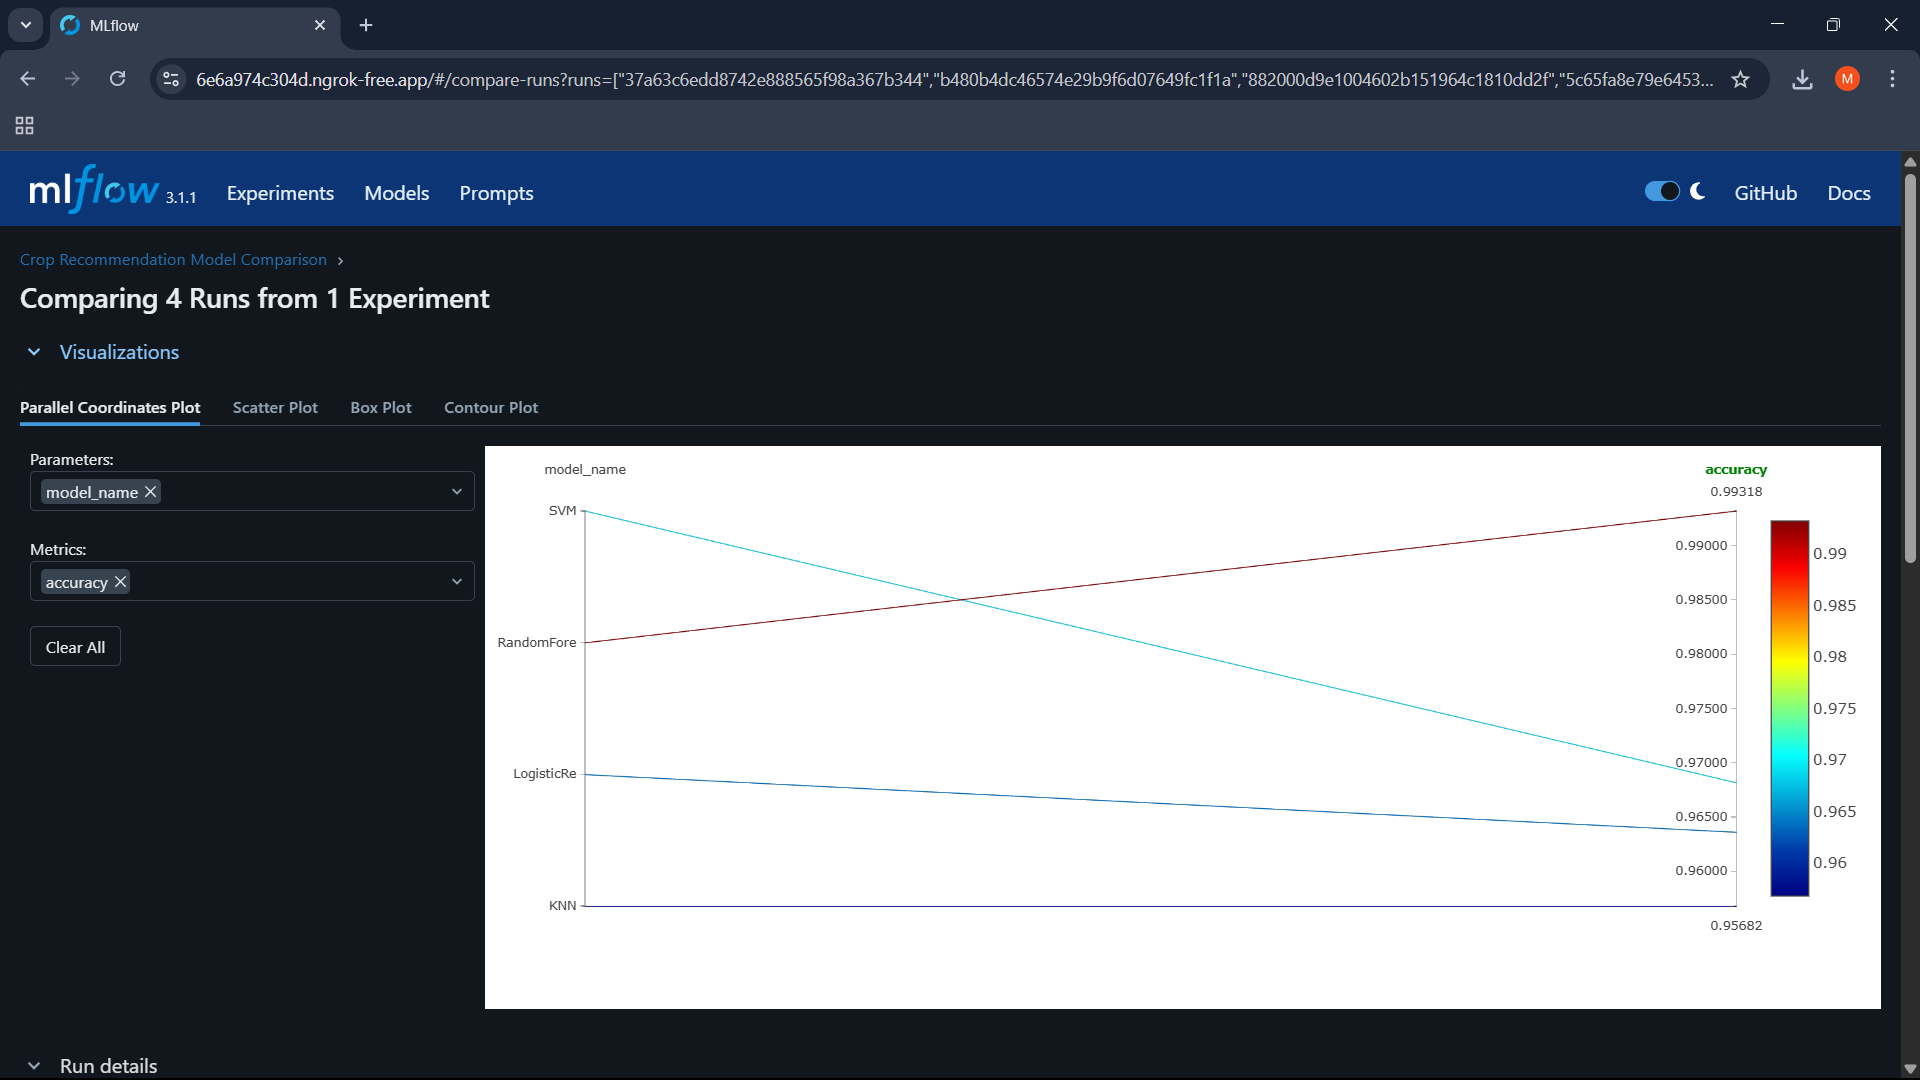

### As we can see RandomForest has the most accuracy so we can package the RandomForest to use it in gradio

In [44]:
import pickle

# Save the trained Random Forest model
with open("random_forest_model.pkl", "wb") as f:
    pickle.dump(models["RandomForest"], f)


### Implement Gradio

In [45]:
import gradio as gr
import pickle
import numpy as np

# Load the trained model
with open("random_forest_model.pkl", "rb") as f:
    model = pickle.load(f)

# Load the label encoder
with open("label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

# Define the prediction function
def predict_crop(N, P, K, temperature, humidity, ph, rainfall):
    input_data = np.array([[N, P, K, temperature, humidity, ph, rainfall]])
    prediction_encoded = model.predict(input_data)
    prediction_label = le.inverse_transform(prediction_encoded)
    return prediction_label[0]  # Return decoded crop name

# Gradio interface
iface = gr.Interface(
    fn=predict_crop,
    inputs=[
        gr.Number(label="Nitrogen (N)"),
        gr.Number(label="Phosphorus (P)"),
        gr.Number(label="Potassium (K)"),
        gr.Number(label="Temperature (°C)"),
        gr.Number(label="Humidity (%)"),
        gr.Number(label="pH"),
        gr.Number(label="Rainfall (mm)")
    ],
    outputs=gr.Text(label="Recommended Crop"),
    title="Crop Recommendation using Random Forest",
    description="Enter the soil and climate values to predict the best crop to grow."
)

iface.launch()


* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.


c:\Users\aswat\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
